In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
from art.attacks.evasion import FastGradientMethod
from art.estimators.classification import TensorFlowV2Classifier
from tensorflow.keras.preprocessing.image import ImageDataGenerator


D:\Tarun\Desktop\mlProj\my_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

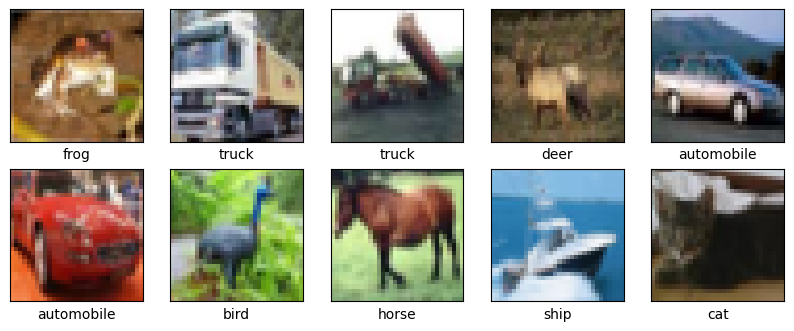

In [4]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

In [5]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(train_images)

In [6]:
# Define the model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10)
])

D:\Tarun\Desktop\mlProj\my_venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 210,602 (822.66 KB)

 Trainable params: 210,602 (822.66 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [9]:
# Callbacks for learning rate reduction and early stopping
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=0.00001)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

In [10]:
# Train the model with data augmentation
history = model.fit(datagen.flow(train_images, train_labels, batch_size=64),
                    epochs=100,
                    validation_data=(test_images, test_labels),
                    callbacks=[reduce_lr, early_stopping])

Epoch 1/100


D:\Tarun\Desktop\mlProj\my_venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


782/782 ━━━━━━━━━━━━━━━━━━━━ 33s 34ms/step - accuracy: 0.2169 - loss: 2.0388 - val_accuracy: 0.4398 - val_loss: 1.5243 - learning_rate: 0.0010
Epoch 2/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.4149 - loss: 1.5884 - val_accuracy: 0.5204 - val_loss: 1.3250 - learning_rate: 0.0010
Epoch 3/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - accuracy: 0.4788 - loss: 1.4347 - val_accuracy: 0.5594 - val_loss: 1.2304 - learning_rate: 0.0010
Epoch 4/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - accuracy: 0.5112 - loss: 1.3506 - val_accuracy: 0.5731 - val_loss: 1.1916 - learning_rate: 0.0010
Epoch 5/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - accuracy: 0.5421 - loss: 1.2886 - val_accuracy: 0.6116 - val_loss: 1.0899 - learning_rate: 0.0010
Epoch 6/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 35ms/step - accuracy: 0.5626 - loss: 1.2410 - val_accuracy: 0.6182 - val_loss: 1.0886 - learning_rate: 0.0010
Epoch 7/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 27s 34ms/step - accuracy: 0.5768 - loss: 

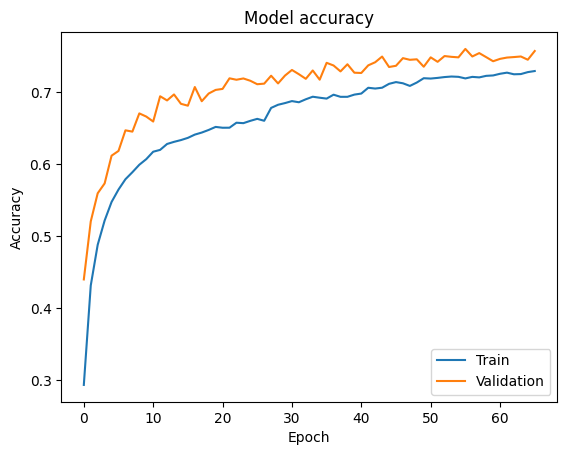

313/313 - 1s - 4ms/step - accuracy: 0.7598 - loss: 0.7025
Test accuracy: 0.7598000168800354


In [11]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f"Test accuracy: {test_acc}")

In [26]:
# Predict labels on clean test data
pred_labels_clean = np.argmax(model.predict(test_images), axis=1)
true_labels = test_labels.flatten()

correctly_classified = 0
same_superclass_count_clean = 0
different_superclass_count_clean = 0

for true_label, pred_label in zip(true_labels, pred_labels_clean):
    if true_label == pred_label:
        correctly_classified += 1
    else:
        true_superclass = get_superclass(true_label, class_names, superclasses)
        pred_superclass = get_superclass(pred_label, class_names, superclasses)
        if true_superclass == pred_superclass:
            same_superclass_count_clean += 1
        else:
            different_superclass_count_clean += 1

print(f"Correctly classified on clean data: {correctly_classified}")
print(f"Same superclass misclassifications on clean data: {same_superclass_count_clean}")
print(f"Different superclass misclassifications on clean data: {different_superclass_count_clean}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Correctly classified on clean data: 7598
Same superclass misclassifications on clean data: 1915
Different superclass misclassifications on clean data: 487


In [12]:
# Adversarial attack using FGSM
classifier = TensorFlowV2Classifier(model=model, nb_classes=10, input_shape=(32, 32, 3), loss_object=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))
attack = FastGradientMethod(estimator=classifier, eps=0.1)
adv_images = attack.generate(x=test_images)


In [13]:
# Plot original and adversarial images
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.03333333..1.0960784].


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1..1.0647058].


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0019607844..1.0882353].


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.07647059..1.017647].


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07254902..0.9196078].


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


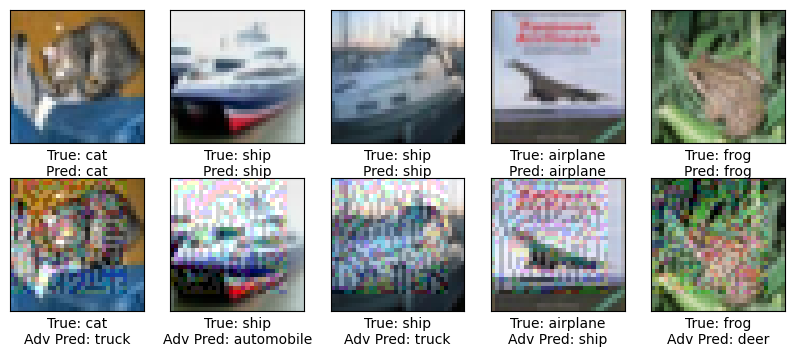

In [14]:
plt.figure(figsize=(10, 4))
for i in range(5):
    # Plot original images
    plt.subplot(2, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i])
    pred_label = np.argmax(model.predict(np.expand_dims(test_images[i], axis=0)), axis=1)
    plt.xlabel(f"True: {class_names[test_labels[i][0]]}\nPred: {class_names[pred_label[0]]}")
    
    # Plot adversarial images
    plt.subplot(2, 5, i + 6)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(adv_images[i])
    adv_pred_label = np.argmax(model.predict(np.expand_dims(adv_images[i], axis=0)), axis=1)
    plt.xlabel(f"True: {class_names[test_labels[i][0]]}\nAdv Pred: {class_names[adv_pred_label[0]]}")
plt.show()

In [16]:
# Iterate over different delta values
delta_values = np.linspace(0.01, 1.0, num=10)
accuracies = []

for delta in delta_values:
    attack = FastGradientMethod(estimator=classifier, eps=delta)
    adv_images = attack.generate(x=test_images)

    # Evaluate model accuracy on adversarial examples
    accuracy = np.mean(np.argmax(model.predict(adv_images), axis=1) == test_labels.flatten())
    accuracies.append(accuracy)


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [18]:
# Identify the maximum delta value where accuracy drops below 10%
threshold_accuracy = 0.15
max_delta_fail = delta_values[np.where(np.array(accuracies) <= threshold_accuracy)[0][0]]


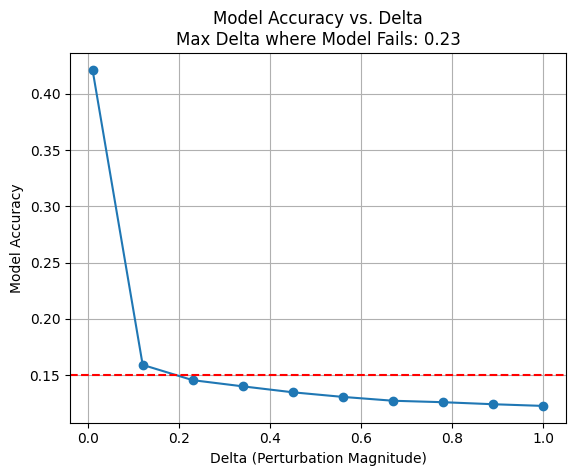

Maximum delta value after which the model fails (accuracy <= 10%): 0.23


In [19]:
# Plot accuracy vs delta
plt.plot(delta_values, accuracies, marker="o")
plt.axhline(y=threshold_accuracy, color='r', linestyle='--')
plt.xlabel("Delta (Perturbation Magnitude)")
plt.ylabel("Model Accuracy")
plt.title(f"Model Accuracy vs. Delta\nMax Delta where Model Fails: {max_delta_fail:.2f}")
plt.grid(True)
plt.show()

print(f"Maximum delta value after which the model fails (accuracy <= 10%): {max_delta_fail:.2f}")

In [21]:
# Define CIFAR-10 superclasses
superclasses = {
    'airplane': 'vehicle', 'automobile': 'vehicle', 'bird': 'animal', 'cat': 'animal',
    'deer': 'animal', 'dog': 'animal', 'frog': 'animal', 'horse': 'animal', 'ship': 'vehicle',
    'truck': 'vehicle'
}

In [22]:
# Function to get superclass
def get_superclass(label, class_names, superclasses):
    class_name = class_names[label]
    return superclasses[class_name]


In [23]:
# Generate adversarial examples with a specific delta (choose a value for delta, e.g., max_delta_fail or any value of interest)
delta = max_delta_fail if max_delta_fail is not None else 0.1
attack = FastGradientMethod(estimator=classifier, eps=delta)
adv_images = attack.generate(x=test_images)

In [24]:
# Predict labels for adversarial examples
pred_labels_adv = np.argmax(model.predict(adv_images), axis=1)
true_labels = test_labels.flatten()


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [25]:
# Analyze misclassifications
same_superclass_count = 0
different_superclass_count = 0

for true_label, pred_label in zip(true_labels, pred_labels_adv):
    if true_label != pred_label:
        true_superclass = get_superclass(true_label, class_names, superclasses)
        pred_superclass = get_superclass(pred_label, class_names, superclasses)
        if true_superclass == pred_superclass:
            same_superclass_count += 1
        else:
            different_superclass_count += 1

print(f"Same superclass misclassifications: {same_superclass_count}")
print(f"Different superclass misclassifications: {different_superclass_count}")

Same superclass misclassifications: 5202
Different superclass misclassifications: 3344


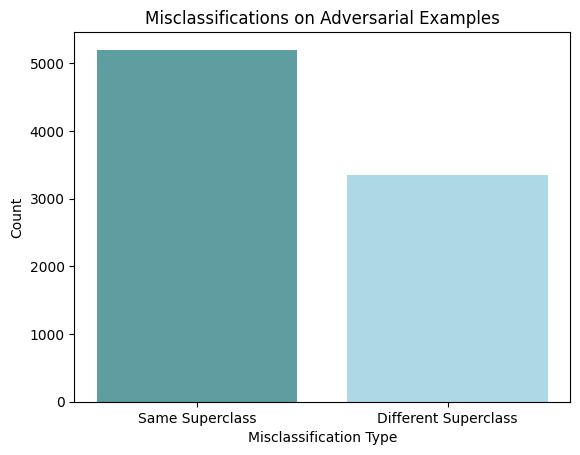

In [40]:
# Plot bar graph for same and different superclass misclassifications on adversarial examples
labels = ['Same Superclass', 'Different Superclass']
counts = [same_superclass_count, different_superclass_count]

plt.bar(labels, counts, color=['cadetblue', 'lightblue'])
plt.xlabel('Misclassification Type')
plt.ylabel('Count')
plt.title('Misclassifications on Adversarial Examples')
plt.show()